### Score and compare
This notebook numbers and scores the 450,000 sequence test sets using AntPack / SAM, then loads
scores assigned by other tools and compares all of the results.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import average_precision_score
from antpack import SequenceScoringTool

if "notebooks" in os.getcwd():
    os.chdir(os.path.join("..", ".."))
    current_dir = os.getcwd()

score_tool = SequenceScoringTool(offer_classifier_option=True)

os.chdir(current_dir)

tt_dir = [f for f in os.listdir() if f.startswith("train_test_data_immunogenicity")]
if len(tt_dir) != 1:
    raise ValueError("Data not downloaded yet, or multiple versions of data downloaded.")

tt_dir = tt_dir[0]

Loading scores from comparators is a little complicated, since the comparators output their results
in different formats. BioPhi, for example, generates excel files, and AbNativ generates
separate files for kappa and lambda chains. First, load BioPhi and AbNativ.

In [2]:
if "results_and_resources" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "results_and_resources", "biophi_results"))

scoring = { chain:{ key:{"scores":[], "species":[], "labels":[]} for key in ["Biophi", "AbNativ", "Hu-mAb"]} for
           chain in ["heavy", "light"] }

for chain in ["abybank_heavy", "abybank_light"]:
    scoring[chain] = { key:{"scores":[], "species":[], "labels":[]} for key in ["AbNativ", "Hu-mAb"]}

for chain in ["light", "heavy"]:
    species_list = ["_".join(fh.split(".xlsx")[0].split("_")[2:]) for fh in os.listdir() if f"{chain}_biophi_" in fh]
    species_list = sorted(species_list)

    for species in species_list:
        species_code = 0
        if species == "human":
            species_code = 1
        bxl = pd.read_excel(f"{chain}_biophi_{species}.xlsx")
        scoring[chain]["Biophi"]["scores"] += bxl["OASis Identity"].tolist()
        scoring[chain]["Biophi"]["species"] += [species for i in range(bxl.shape[0])]
        scoring[chain]["Biophi"]["labels"] += [species_code for i in range(bxl.shape[0])]

        if chain == "heavy":
            bxl = pd.read_csv(f"../abnativ_results/heavy_abnativ_{species}.txt")
            scoring["heavy"]["AbNativ"]["scores"] += bxl.iloc[:,0].tolist()
            scoring["heavy"]["AbNativ"]["species"] += [species for i in range(bxl.shape[0])]
            scoring["heavy"]["AbNativ"]["labels"] += [species_code for i in range(bxl.shape[0])]
        else:
            for chain_subtype in ["kappa", "lambda"]:
                fname = f"light_abnativ_{species}_{chain_subtype}.txt"
                if fname not in os.listdir("../abnativ_results"):
                    continue
                bxl = pd.read_csv(os.path.join("..", "abnativ_results", fname))
                scoring["light"]["AbNativ"]["scores"] += bxl.iloc[:,0].tolist()
                scoring["light"]["AbNativ"]["species"] += [species for i in range(bxl.shape[0])]
                scoring["light"]["AbNativ"]["labels"] += [species_code for i in range(bxl.shape[0])]

Next, we're going to number and score all of the test sequences using AntPack / SAM. This should take a few
minutes. Note that we score the test set both in classification mode and in scoring mode.

In [3]:
import time

if "results_and_resources" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "results_and_resources"))


for chain in ["heavy", "light"]:
    st = time.time()
    scoring[chain]["SAM"] = {"scores":[],"species":[], "labels":[]}
    os.chdir(os.path.join(current_dir, tt_dir, f"{chain}_chain", "test_sample_sequences"))
    flist = [f for f in os.listdir() if f.endswith("fasta")]
    flist = sorted(flist)

    for fname in flist:
        print(fname)
        with open(fname, "r") as fhandle:
            seqs = [str(s.seq) for s in SeqIO.parse(fhandle, "fasta")]

        species = fname.split(".fasta")[0].split("test_subsample_")[1]
        scoring[chain]["SAM"]["scores"] += score_tool.score_seqs(seqs, mode="score").tolist()
        scoring[chain]["SAM"]["species"] += [species for s in seqs]
        if species == "human":
            scoring[chain]["SAM"]["labels"] += np.ones((len(seqs))).tolist()
        else:
            scoring[chain]["SAM"]["labels"] += np.zeros((len(seqs))).tolist()

    print(f"Time elapsed: {time.time() - st}")
    
os.chdir(os.path.join(current_dir, tt_dir, "abybank_compiled_data", f"{chain}_abybank"))
scoring[f"abybank_{chain}"]["SAM"] = {"scores":[],"species":[], "labels":[]}
flist = [f for f in os.listdir() if f.endswith(".fa")]
flist = sorted(flist)
        
for fname in flist:
    print(fname)
    with open(fname, "r") as fhandle:
        seqs = [str(s.seq) for s in SeqIO.parse(fhandle, "fasta")]

    species = fname.split("_seqs.fa")[0].split(f"{chain}_")[1]
    scoring[f"abybank_{chain}"]["SAM"]["scores"] += score_tool.score_seqs(seqs).tolist()
    scoring[f"abybank_{chain}"]["SAM"]["species"] += [species for s in seqs]
    if species == "human":
        scoring[f"abybank_{chain}"]["SAM"]["labels"] += np.ones((len(seqs))).tolist()
    else:
        scoring[f"abybank_{chain}"]["SAM"]["labels"] += np.zeros((len(seqs))).tolist()

for chain in ["heavy", "light"]:
    scoring[chain]["SAM_classifier"] = {"scores":[],"species":[], "labels":[]}
    os.chdir(os.path.join(current_dir, tt_dir, f"{chain}_chain", "test_sample_sequences"))
    flist = [f for f in os.listdir() if f.endswith("fasta")]
    flist = sorted(flist)

    for fname in flist:
        print(fname)
        with open(fname, "r") as fhandle:
            seqs = [str(s.seq) for s in SeqIO.parse(fhandle, "fasta")]

        species = fname.split(".fasta")[0].split("test_subsample_")[1]
        scoring[chain]["SAM_classifier"]["scores"] += score_tool.score_seqs(seqs, mode="classifier").tolist()
        scoring[chain]["SAM_classifier"]["species"] += [species for s in seqs]
        if species == "human":
            scoring[chain]["SAM_classifier"]["labels"] += np.ones((len(seqs))).tolist()
        else:
            scoring[chain]["SAM_classifier"]["labels"] += np.zeros((len(seqs))).tolist()

test_subsample_camel.fasta
test_subsample_human.fasta
test_subsample_mouse_balbc.fasta
test_subsample_mouse_c576.fasta
test_subsample_rabbit.fasta
test_subsample_rat.fasta
test_subsample_rhesus.fasta
Time elapsed: 66.26064872741699
test_subsample_human.fasta
test_subsample_mouse_balbc.fasta
test_subsample_rhesus.fasta
Time elapsed: 27.409822702407837
light_guinea_seqs.fa
light_horse_seqs.fa
light_human_seqs.fa
light_rabbit_seqs.fa
light_rhesus_seqs.fa
test_subsample_camel.fasta
test_subsample_human.fasta
test_subsample_mouse_balbc.fasta
test_subsample_mouse_c576.fasta
test_subsample_rabbit.fasta
test_subsample_rat.fasta
test_subsample_rhesus.fasta
test_subsample_human.fasta
test_subsample_mouse_balbc.fasta
test_subsample_rhesus.fasta


Now we continue to load other scores: IGLM, Progen, AbLSTM, AntiBERTy (log-likelihood not classifier --
the AntiBERTy classifier is scored in a separate notebook), Hu-mAb.

In [4]:
os.chdir(os.path.join(current_dir, "results_and_resources"))

for tool in ["iglm", "progen", "ablstm", "antiberty"]:
    for chain in ["heavy", "light"]:
        bxl = pd.read_csv(f"{chain}_{tool}_scores.txt", header=None)

        #Strangely, some tools (e.g. ablstm) assign lower scores to human sequences.
        #We therefore have to label them in reverse or their ROC-AUC will be VERY poor.
        if tool != "iglm":
            labels = ((bxl.iloc[:,0] != "human") * 1).tolist()
        else:
            labels = (bxl.iloc[:,0] == "human") * 1
        scoring[chain][tool] = {"scores":bxl.iloc[:,-1].astype(float).tolist(),
                                     "species":bxl.iloc[:,0].tolist(), "labels":labels}


os.chdir("humab_results")

for chain in ["heavy", "light"]:
    flist = [f for f in os.listdir() if f.endswith(f"{chain}.txt") and "HUMAB" in f]
    flist = sorted(flist)

    for fname in flist:
        species = "_".join(fname.split("HUMAB")[0].split("_")[2:])
        species_code = 0
        if species == "human":
            species_code = 1

        with open(fname, "r") as fhandle:
            _ = fhandle.readline()
            for line in fhandle:
                score = np.array([float(x) for x in line.strip().split(",")]).max()
                scoring[chain]["Hu-mAb"]["scores"].append(score)
                scoring[chain]["Hu-mAb"]["species"].append(species)
                scoring[chain]["Hu-mAb"]["labels"].append(species_code)

In [5]:
os.chdir(os.path.join(current_dir, "results_and_resources", "humab_abybank"))

for chain in ["heavy", "light"]:
    species_list = [fh.split("_HUMAB.txt")[0].split("_")[1] for fh in os.listdir() if f"{chain}_" in fh]
    species_list = sorted(species_list)

    for species in species_list:
        species_code = 0
        if species == "human":
            species_code = 1

        with open(f"{chain}_{species}_HUMAB.txt", "r") as fhandle:
            _ = fhandle.readline()
            for line in fhandle:
                score = np.array([float(x) for x in line.strip().split(",")]).max()
                scoring[f"abybank_{chain}"]["Hu-mAb"]["scores"].append(score)
                scoring[f"abybank_{chain}"]["Hu-mAb"]["species"].append(species)
                scoring[f"abybank_{chain}"]["Hu-mAb"]["labels"].append(species_code)

os.chdir(os.path.join(current_dir, "results_and_resources"))

Plot the score distributions...

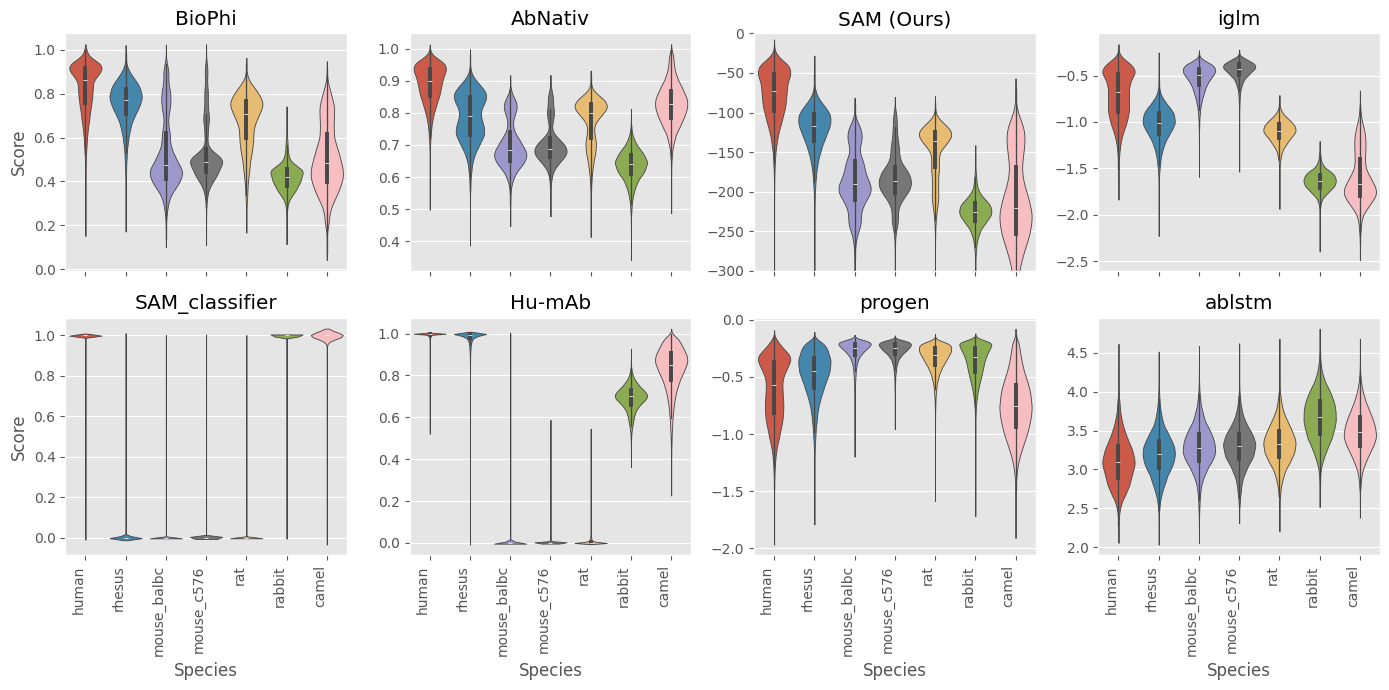

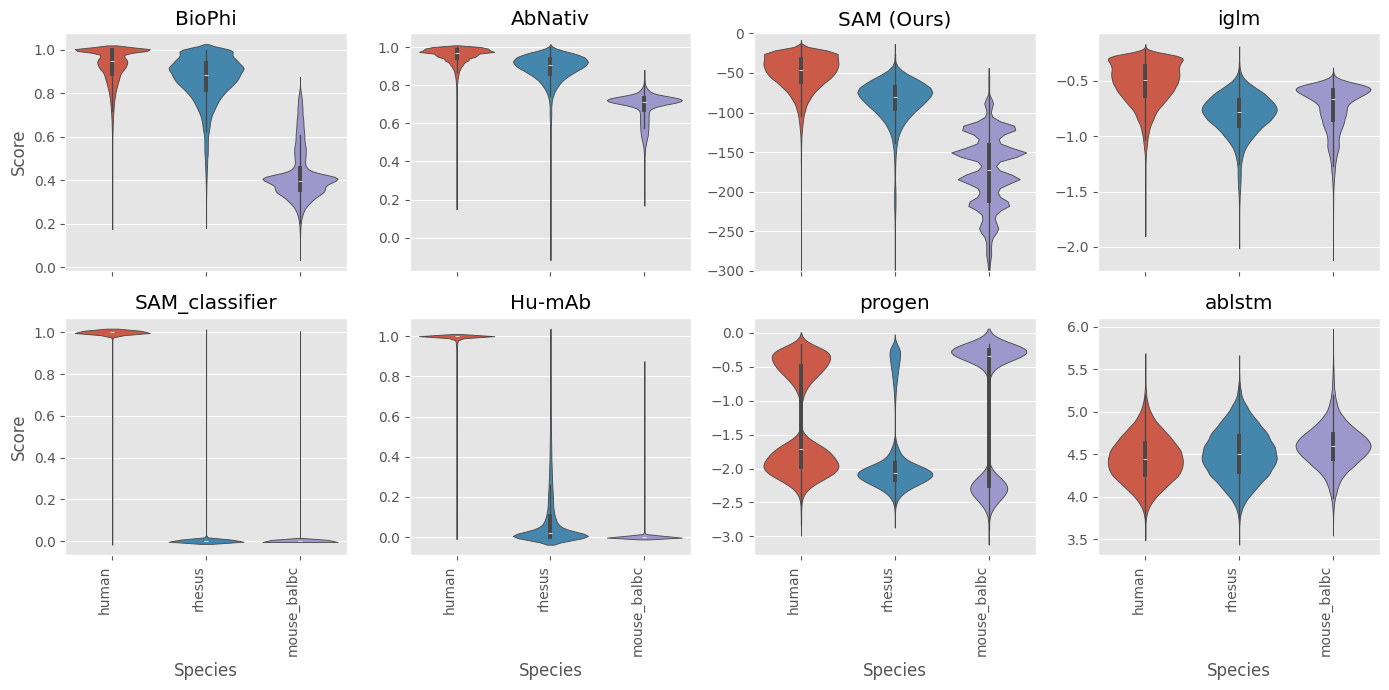

In [6]:
plt.style.use("ggplot")
preferred_order = {"heavy":["human", "rhesus", "mouse_balbc", "mouse_c576", "rat", "rabbit", "camel"],
                      "light":["human", "rhesus", "mouse_balbc"]}

tool_list = ['Biophi', 'AbNativ', 'SAM', 'iglm', 'SAM_classifier', 'Hu-mAb', 'progen', 'ablstm']

for chain in ["heavy", "light"]:
    fig, ((ax1,ax2,ax3,ax4), (ax5,ax6,ax7,ax8)) = plt.subplots(2,4, figsize=(14,7), sharex=True)
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    chain_scores = scoring[chain]
    
    for tool, ax in zip(tool_list, axes):
        sns.violinplot(y=chain_scores[tool]["scores"], x=chain_scores[tool]["species"],
                    hue=chain_scores[tool]["species"], ax=ax, order=preferred_order[chain],
                   hue_order=preferred_order[chain])
    
    
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_ha('right')
        if tool == "SAM":
            ax.set_title(f"{tool} (Ours)")
            #Some sequences receive extremely low scores from SAM so we clip the plot
            #for better visibility.
            ax.set_ylim(-300,0)
        elif tool == "Biophi":
            ax.set_title("BioPhi")
        else:
            ax.set_title(f"{tool}")

    ax5.set_xlabel("Species")
    ax6.set_xlabel("Species")
    ax7.set_xlabel("Species")
    ax8.set_xlabel("Species")
    
    ax1.set_ylabel("Score")
    ax5.set_ylabel("Score")
    #plt.suptitle(f"Human-likeness scores for different models\non OAS test set {chain} chains", y=1.05)
    plt.tight_layout()
    plt.savefig(f"Score distributions chain {chain}.png")
    plt.show()

Next, calculate AUC-ROC and AUC-PRC scores. We bootstrap here to estimate a confidence interval
and figure out what performance would look like on the full test set. Note that as a result
this part is a little slow and may take 5 minutes or so.

In [9]:
combined_results = {"tool":[], "chain":[], "AUC-ROC":[], "AUC-ROC_LCB":[], "AUC-ROC_UCB":[],
                    "AUC-PRC":[], "AUC-PRC_LCB":[], "AUC-PRC_UCB":[]}

tools = ['Biophi', 'AbNativ', 'Hu-mAb', 'SAM', 'SAM_classifier', 'iglm', 'progen',
                 'ablstm', 'antiberty']

for chain in ["heavy", "light"]:
    print(f"AUC-ROC results, chain {chain}")

    for tool in tools:
        auc_values = []
        gt_scores = np.array(scoring[chain][tool]["labels"])
        input_scores = np.array(scoring[chain][tool]["scores"])
        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        score = roc_auc_score(gt_scores, input_scores)
        combined_results["tool"].append(tool)
        combined_results["chain"].append(chain)
        combined_results["AUC-ROC"].append(roc_auc_score(gt_scores, input_scores))
        combined_results["AUC-ROC_LCB"].append(auc_values[25])
        combined_results["AUC-ROC_UCB"].append(auc_values[975])

        print(f"{tool}:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")

    print("\n")

print("\n\n\n")

for chain in ["heavy", "light"]:
    print(f"AUC-PRC results, chain {chain}")

    for tool in tools:
        auc_values = []
        gt_scores = np.array(scoring[chain][tool]["labels"])
        if tool in ["ablstm", "antiberty", "progen"]:
            gt_scores -= 1
            gt_scores[gt_scores<0] = 1
        input_scores = np.array(scoring[chain][tool]["scores"])

        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(average_precision_score(gt_scores[idx], input_scores[idx]))

        
        score = average_precision_score(gt_scores, input_scores)
        
        auc_values = np.sort(np.array(auc_values))
        combined_results["AUC-PRC"].append(score)
        combined_results["AUC-PRC_LCB"].append(auc_values[25])
        combined_results["AUC-PRC_UCB"].append(auc_values[975])

        print(f"{tool}:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")

    print("\n")

AUC-ROC results, chain heavy
Biophi:	0.8813123865197848	LCB: 0.8798511688731377	UCB:0.882739586238036
AbNativ:	0.8980648644187643	LCB: 0.8965807011177043	UCB:0.899396083238357
Hu-mAb:	0.9429276592918583	LCB: 0.9421480661973125	UCB:0.9436683449227825
SAM:	0.9537544028005602	LCB: 0.9528452277390939	UCB:0.9547312741157983
SAM_classifier:	0.8809223223444689	LCB: 0.8798791356678201	UCB:0.8820537489523217
iglm:	0.7949050929785957	LCB: 0.7932961633023664	UCB:0.7966289124751696
progen:	0.6914346961392279	LCB: 0.6890908075554696	UCB:0.6938827051137008
ablstm:	0.747211499379876	LCB: 0.7449030358108523	UCB:0.7496203771364567
antiberty:	0.5425644590918184	LCB: 0.5402235153103361	UCB:0.5449405778722132


AUC-ROC results, chain light
Biophi:	0.849089699276095	LCB: 0.8471459042325946	UCB:0.8508984552953794
AbNativ:	0.9158565490885548	LCB: 0.9144879063218698	UCB:0.9171855346775352
Hu-mAb:	0.9992920938050707	LCB: 0.9991847565122202	UCB:0.9994056483943257
SAM:	0.9323678427042756	LCB: 0.9311158890340685	

Finally, let's look at the performance of another classifier (Hu-mAb) on light chains for more diverse
species. Classifiers can achieve better accuracy on species that are present in their training set but
are less robust and tend to exhibit erratic behavior on species not present in their training set. In
this case, for example, we see that Hu-mAb assigns very low scores (close to 0) for mouse light chains (see above),
but assigns scores > 0.8 -- very similar to what it assigns to human and identical to what it assigns to
humanized sequences -- to light chains from horses, guinea pigs and rabbits.
That's not because these species are more human, that's because they're not
present in Hu-mAb's training set. Scoring using a generative model (e.g. SAM, AbNativ) 
without first converting it to a classifier doesn't show this behavior. (Generative models
can be converted to a classifier by building a generative model for each species, and as we
show above with SAM-classifier this exhibits behavior very similar to a classification model
like Hu-mAb).

AUC-ROC: Hu-mAb:	0.97228	LCB: 0.9663614634634412	UCB:0.977886852792307
AUC-PRC: Hu-mAb:	0.9611753421549888	LCB: 0.9513580890536179	UCB:0.9703314956770549
AUC-ROC: SAM:	0.9959577777777778	LCB: 0.9933189886127108	UCB:0.9981598397015918
AUC-PRC: SAM:	0.9972078755637687	LCB: 0.9956252177746591	UCB:0.998554582882289


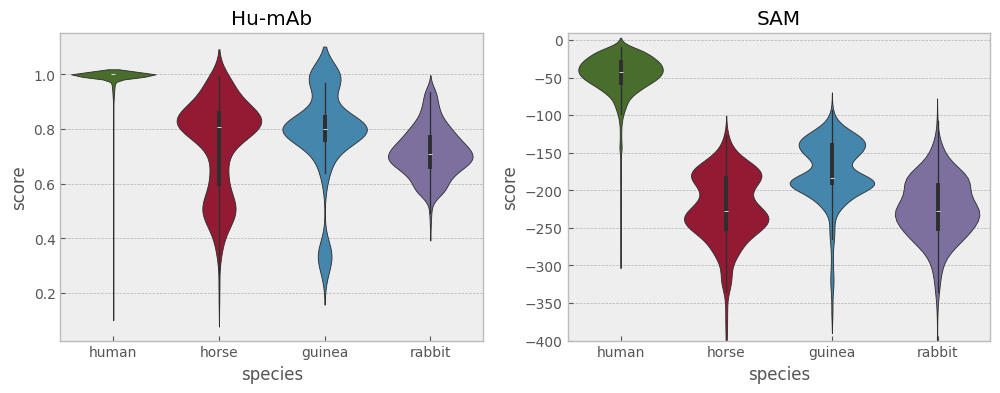

In [10]:
plt.style.use('bmh')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

species_order = ["human", "horse", "guinea", "rabbit"]



for chain in ["abybank_light"]:
    for ax, tool in zip([ax1, ax2], ['Hu-mAb', 'SAM']):
        rng = np.random.default_rng(123)
        df = pd.DataFrame.from_dict(scoring[chain][tool])
        subset = df[df['species'].isin(['rabbit', 'horse', 'guinea'])]
        #There are more human than nonhuman, so we randomly select a subset of the human
        #of equal size to the number of nonhuman.
        human_subset = df[df['species']=="human"]
        idx = rng.permutation(human_subset.shape[0])
        human_subset = human_subset.iloc[idx[:1500],:]
        subset = pd.concat([subset, human_subset], axis=0)

        sns.violinplot(x="species", y="scores", hue="species", data=subset, ax=ax, order=species_order)
        ax.set_ylabel("score")
        ax.set_title(tool)
        if tool == "SAM":
            ax.set_ylim(-400,10)

        gt_scores = subset['labels'].values
        input_scores = subset['scores'].values
        auc_values, prc_values = [], []

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))
            prc_values.append(average_precision_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        prc_values = np.sort(np.array(prc_values))
        print(f"AUC-ROC: {tool}:\t{roc_auc_score(gt_scores, input_scores)}\t"
              f"LCB: {auc_values[25]}\tUCB:{auc_values[975]}")
        print(f"AUC-PRC: {tool}:\t{average_precision_score(gt_scores, input_scores)}\t"
              f"LCB: {prc_values[25]}\tUCB:{prc_values[975]}")

In [11]:
combined_df = pd.DataFrame.from_dict(combined_results)
combined_df

,tool,chain,AUC-ROC,AUC-ROC_LCB,AUC-ROC_UCB,AUC-PRC,AUC-PRC_LCB,AUC-PRC_UCB
0,Biophi,heavy,0.881312,0.879851,0.882740,0.677526,0.673666,0.681526
1,AbNativ,heavy,0.898065,0.896581,0.899396,0.648836,0.643743,0.653420
2,Hu-mAb,heavy,0.942928,0.942148,0.943668,0.664321,0.660623,0.668208
3,SAM,heavy,0.953754,0.952845,0.954731,0.871152,0.868930,0.873439
4,SAM_classifier,heavy,0.880922,0.879879,0.882054,0.473080,0.469798,0.476625
5,iglm,heavy,0.794905,0.793296,0.796629,0.332337,0.329081,0.336015
6,progen,heavy,0.691435,0.689091,0.693883,0.112936,0.111956,0.114004
7,ablstm,heavy,0.747211,0.744903,0.749620,0.105188,0.104285,0.106146
8,antiberty,heavy,0.542564,0.540224,0.544941,0.140796,0.139511,0.142172
9,Biophi,light,0.849090,0.847146,0.850898,0.699792,0.695529,0.703928


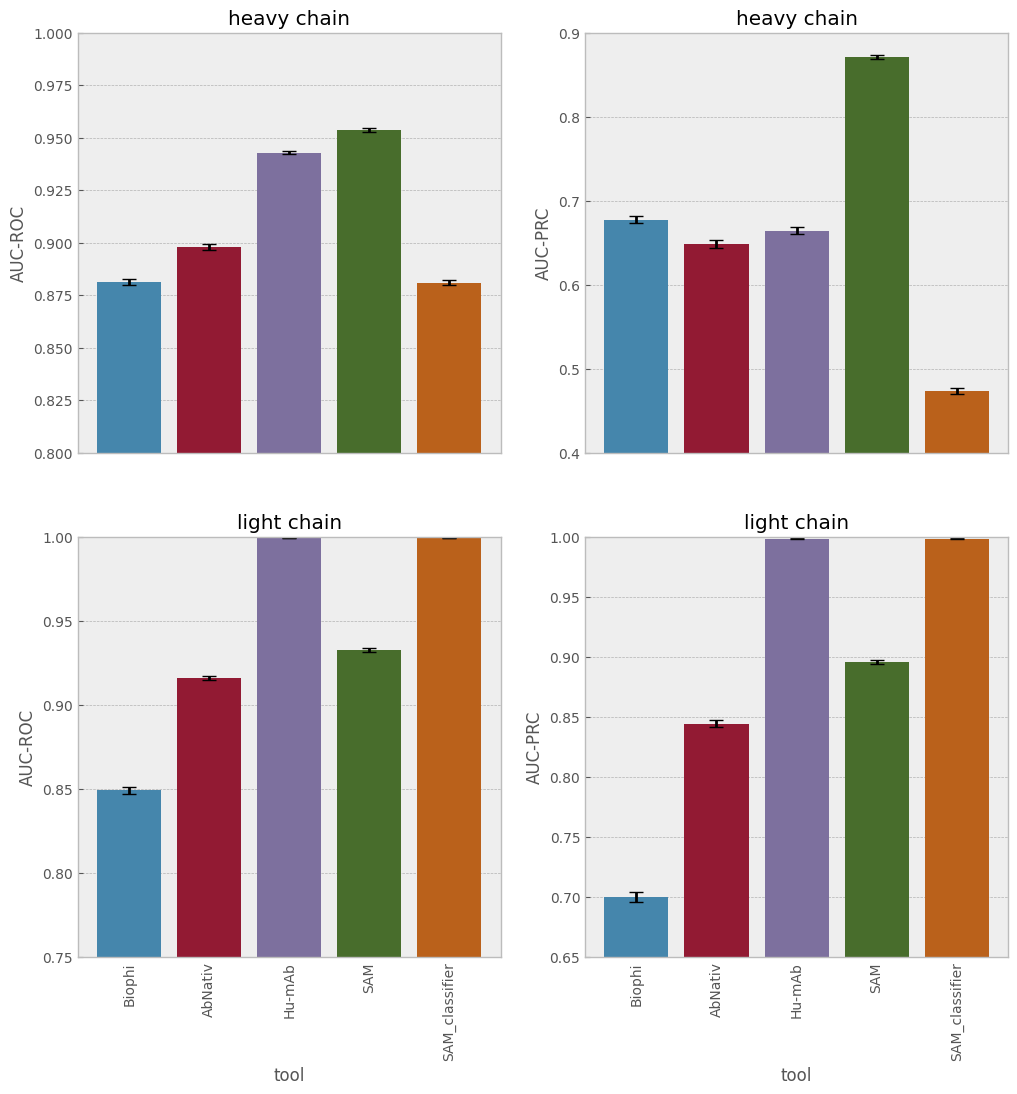

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,12), sharex=True)
axes = [ax1, ax2, ax3, ax4]
plot_details = [("heavy", "AUC-ROC", ax1), ("heavy", "AUC-PRC", ax2),
                ("light", "AUC-ROC", ax3), ("light", "AUC-PRC", ax4)]

plt.style.use("bmh")

for (chain, datatype, ax) in plot_details:
    subset = combined_df[combined_df["chain"]==chain]
    subset = subset[subset["tool"].isin(tools[:5])]
    sns.barplot(x="tool", y=datatype, data=subset, hue="tool", ax=ax)

    err = np.stack([subset[datatype].values - subset[f"{datatype}_LCB"].values,
                    subset[f"{datatype}_UCB"].values - subset[datatype].values])
    ax.errorbar(x=np.arange(5), y=subset[datatype].values,
                 yerr=err, fmt="none", color="black", capsize=5)
    ax.set_title(f"{chain} chain")

    if chain == "light":
        if datatype == "AUC-PRC":
            ax.set_ylim(0.65,1.0)
        else:
            ax.set_ylim(0.75,1.0)
    else:
        if datatype == "AUC-PRC":
            ax.set_ylim(0.4, 0.9)
        else:
            ax.set_ylim(0.8, 1.0)

_ = ax3.set_xticks(np.arange(5), tools[:5], rotation=90)
_ = ax4.set_xticks(np.arange(5), tools[:5], rotation=90)

os.chdir(current_dir)
plt.savefig("performance.png")